## Logistic Regression

Download the dataset 
    news20.binary dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#news20.binary

### Problem is described below:
$$\mbox{minimize}_{x\in\mathbb{R}^d,\beta\in\mathbb{R}} \ \lambda \|x\|_1 + \frac{1}{n} \sum_{i=1}^n \log (1+ \exp(-b_i(a_i^Tx + \beta)))$$
 
This code solves the problem using:

1) Proximal gradient descent

2) Accelerated proximal gradient descent

3) Proximal coordinate descent

4) Accelerated proximal coordinate descent

The model parameter $\lambda$ is tuned. The objective function (y-axis) vs running time in sec (x-axis) for all algorithms are shown in the same plot. The generalization error is also reportd in the end.

For training split the data into training (the first 15996 datapoints), validation (the next 2000 datapoints) and testing (the next 2000 datapoints).

In [5]:
import sys

path = "/home/aa2deshm/Desktop/libsvm-3.24/python"
sys.path.append(path)
from svmutil import *
path = "/home/aa2deshm/Desktop/libsvm-3.24/"

import matplotlib.pyplot as plt

import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import time
import sklearn.feature_extraction
import math
from scipy.sparse import csr_matrix
import random
from numpy.linalg import norm
from scipy import sparse

np.set_printoptions(threshold=np.inf)

In [6]:
################### reading data #######################

b_news, A_news = svm_read_problem("news20.binary")

change = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
mat_news = change.fit_transform(A_news)
label_news = np.array([b_news]).T
num_f = mat_news.shape[1]

n = mat_news.shape[0]
ones = np.ones((n,1))
mat_news = hstack([ones, mat_news]).tocsr()

train_mat_news, val_mat_news, train_label_news, val_label_news = train_test_split(mat_news, label_news, test_size=0.2)

val_mat_news, test_mat_news, val_label_news, test_label_news = train_test_split(val_mat_news, val_label_news, test_size=0.5)

###################
print(train_mat_news.shape)
print(train_label_news.shape)
print(weights_news.shape)

print(val_mat_news.shape)
print(val_label_news.shape)

################### reading data #######################

(15996, 1355192)
(15996, 1)
(1355192, 1)
(2000, 1355192)
(2000, 1)


In [7]:
def obj_fx(a, w, b):
    obj = (1/b.shape[0])*np.sum(np.log(1+np.exp(-b*a.dot(w))))
    return obj

def grad_fx(a, w, b):
    term = ((1/b.shape[0])*np.sum(a.multiply(-b/(1+np.exp(b*a.dot(w)))),axis = 0)).T
    grad = np.array(term)
    return grad

def prox_op(u, alpha, lambda_):
    prox = np.where(u >= alpha*lambda_, u - alpha*lambda_, u)
    prox = np.where(np.absolute(u) <= alpha*lambda_, 0, prox)
    prox = np.where(u <= -alpha*lambda_, u + alpha*lambda_, prox)
    return prox


def ar_ls(xk, fx_curr, Fx_net, gradi, lambda_, b, a):
    
    l_xk = Fx_net
    iteration = 1
    alpha = 1.
    theta = 0.5
    while True:
        u = xk - alpha * gradi
        x_alpha = prox_op(u, alpha, lambda_)
        Fx_alpha = obj_fx(a, x_alpha, b) + lambda_*norm(x_alpha,1)
        l_xalpha = lambda_*norm(x_alpha,1) + fx_curr + (gradi.T).dot(x_alpha - xk)
        if Fx_alpha <= Fx_net - theta*(l_xk - l_xalpha):
            break
        alpha = alpha/2.
        iteration += 1
    return x_alpha,Fx_alpha, alpha

def prox_GD(x, lambda_, b, a, epsilon, max_iterations): 
    st_time = time.time()
    time_list = []
    max_iter = 1
    fx_list = []
    while True:        
        fx_curr = obj_fx(a, x, b)
        Fx_net = fx_curr + lambda_*norm(x,1)
        gradi = grad_fx(a, x,b)
        x_alpha,Fx_alpha, alpha = ar_ls(x, fx_curr, Fx_net, gradi, lambda_, b, a)
        
        g_map = (1./alpha) * (x - x_alpha)
        fx_list.append(Fx_alpha)
        time_list.append(time.time() - st_time)
        x = x_alpha
        if norm(g_map,2) <= epsilon or max_iter >= max_iterations: 
            break
        max_iter += 1
    return x,fx_list,time_list

In [8]:
def find_error(weights,b,a):
    pred = 1./(np.exp(-a*weights)+1)
    pred = np.where(pred > 0.5, 1.,-1.)
    error = np.sum(abs(pred - b))
    gen_error = error/len(pred)
    return gen_error

In [9]:
lambda_=0.0001
max_iterations = 1000
epsilon = 1.0e-2

weights_news = np.random.normal(0.0,1.0,[train_mat_news.shape[1],1])/train_mat_news.shape[1]

final_w1, fx_list1, time_list1 = prox_GD(weights_news, lambda_, train_label_news, train_mat_news, epsilon, max_iterations)
error1 = find_error(final_w1,val_label_news,val_mat_news)
print("Prediction error is:" , error1)

Prediction error is: 0.412


In [10]:
def acc_prox_GD(x, lambda_, b, a, epsilon, max_iterations):
    max_iter = 1
    fx_list = []
    st = time.time()
    time_list = []
    y = x
    t = 1
    t_prev = t    
    iteration = 1
    
    while True:
        
        fx_curr = obj_fx(a, x, b)
        Fx_net = fx_curr + lambda_*norm(x,1)
        gradi = grad_fx(a, x,b)
        
        x_alpha,Fx_alpha, alpha = ar_ls(y, fx_curr, Fx_net, gradi, lambda_, b, a)
        g_map = (1/alpha) * (y - x_alpha)
        t = (1 + (1+4*(t**2))**(0.5))/2.
        y = x_alpha + ((t_prev-1)/t)*(x_alpha - x)
        t_prev = t
        fx_list.append(Fx_alpha)
        time_list.append(time.time() - st)
        x = x_alpha
        if norm(g_map,2) <= epsilon or max_iter >= max_iterations:
            break
        max_iter += 1        
    return x,fx_list,time_list

In [11]:
lambda_=0.0001
max_iterations = 2000
epsilon = 1.0e-2

weights_news = np.random.normal(0.0,1.0,[train_mat_news.shape[1],1])/train_mat_news.shape[1]

final_w2, fx_list2, time_list2 = acc_prox_GD(weights_news, lambda_, train_label_news, train_mat_news, epsilon, max_iterations)
error2 = find_error(final_w2,val_label_news,val_mat_news)
print("Prediction error is:" , error2)

Prediction error is: 0.419


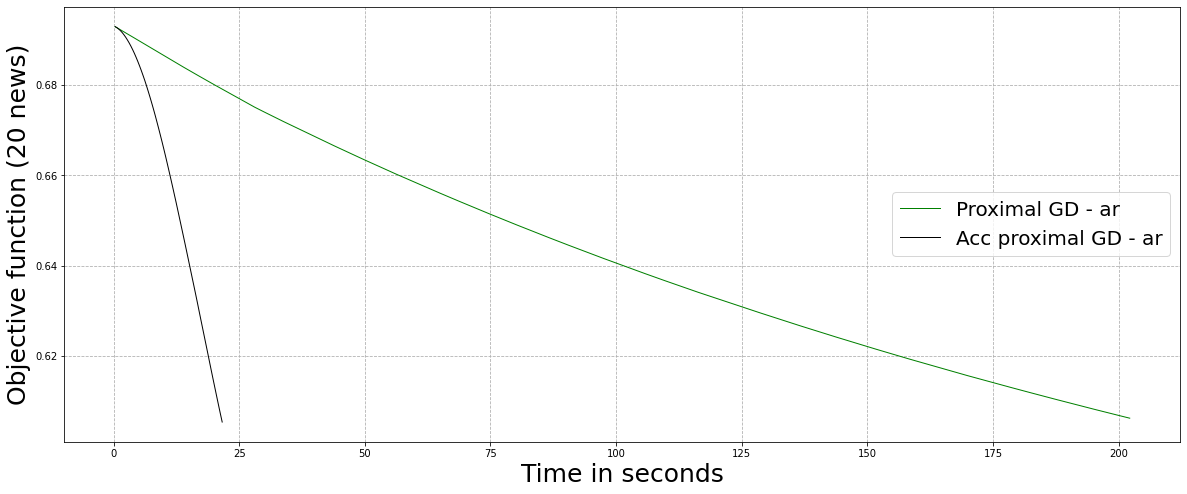

In [438]:
fig = plt.figure(figsize=(20, 8))
plt.plot(time_list1,fx_list1, label=("Proximal GD - ar"), linewidth=1.0, color ="green")
plt.plot(time_list2,fx_list2, label=("Acc proximal GD - ar"), linewidth=1.0, color ="black")
#plt.plot(time_array_cood,fx_array_cood, label=("cood proximal"), linewidth=1.0, color ="blue")


plt.legend(prop={'size': 20},loc="right")
plt.xlabel("Time in seconds", fontsize=25)
plt.ylabel("Objective function (20 news)", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

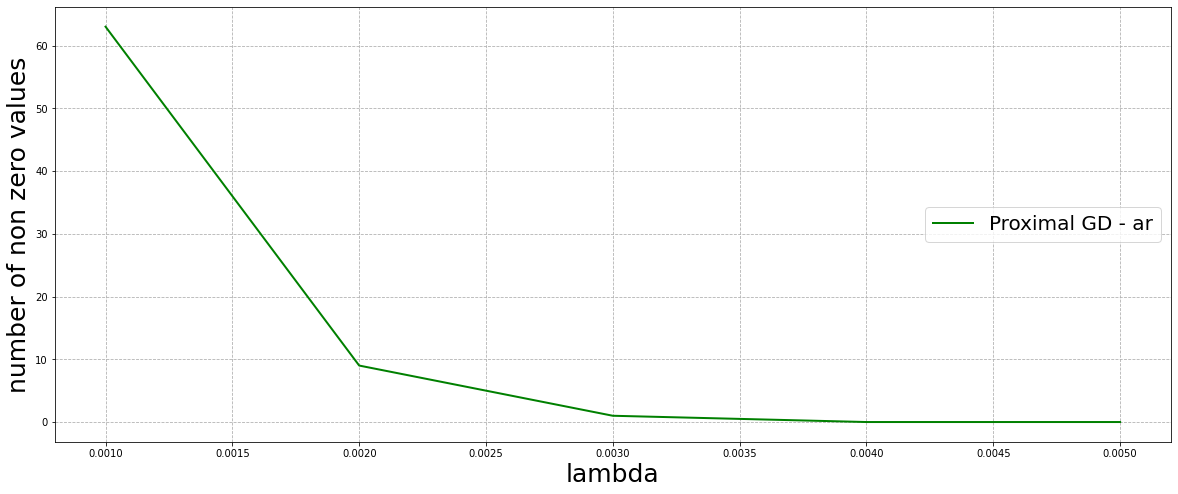

In [439]:
weights_news = np.random.normal(0.0,1.0,[train_mat_news.shape[1],1])/train_mat_news.shape[1]

lam_list = [0.001, 0.002, 0.003, 0.004, 0.005]
y_axis_nnz =[]
for i in range(len(lam_list)):
    final_w1, fx_list1, time_list1 = prox_GD(weights_news, lam_list[i], train_label_news, train_mat_news, epsilon, max_iterations)
    nnz = np.count_nonzero(final_w1)
    y_axis_nnz.append(nnz)

fig = plt.figure(figsize=(20, 8))
plt.plot(lam_list,y_axis_nnz, label=("Proximal GD - ar"), linewidth=2.0, color ="green")
plt.legend(prop={'size': 20},loc="right")
plt.xlabel("lambda", fontsize=25)
plt.ylabel("number of non zero values", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()       

Note that: with the increase in Lambda, there is a decrease in number of non-zero values. The number of non-zero values go to zero as lamba becomes close to 0.005.  

## Label Propagation

In [440]:
# Load datasets from sklearn
from sklearn import datasets

# Load the digits dataset.
# See here for a distription of this dataset: 
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
digits = datasets.load_digits()

# Briefly, this dataset has 1797 images of digits. The digits are from 0 to 9.
# There are about 180 images per digit.

# digits.data includes the vectorized images of the digits
# digits.target includes the labels of the images
# digits.images includes the images in non-vectorized format

# Example: number 0
import matplotlib.pyplot as plt

### Problem1: 
Let x_i and x_j be two vectorized images.
Compute their pairwise similarity by
$$ 
w_{ij} = \exp(-\gamma \|x_i-x_j\|_2^2),
$$
where $\gamma$ is parameter tha controls the importance of the distance $\|x_i-x_j\|_2^2$. If $\gamma=1/(2\sigma^2)$ then this is called the Gaussian kernel and $\sigma^2$ represents the variance.

We can compute the similarities by using: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html. 

In [441]:
# Example
import sklearn

# Pairwise weights matrix
W = sklearn.metrics.pairwise.rbf_kernel(digits.data)

# Remove self-similarity
import numpy as np
W = W - np.eye(len(W))

# Sparsify (tune the tolerance parameter for your problem)
tol = 1e-16
W[abs(W) < tol] = 0.0


In [442]:
from sklearn.metrics import precision_recall_fscore_support

def prepare_data(num_known):
    known_label = []
    for i in range(num_known):
        a = np.array(np.where(digits.target == i))[0]
        a = a[0:num_known]
        known_label = np.append(known_label, a)

    train_data = []
    train_label = []
    test_data = []
    test_label = []

    for i in range(len(digits.target)):
        if i in known_label:
            train_data.append(digits.data[i])
            train_label.append(digits.target[i])
        else:
            test_data.append(digits.data[i])
            test_label.append(digits.target[i])
            
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    test_data = np.array(test_data)
    test_label = np.array(test_label)

    W_bar = sklearn.metrics.pairwise.rbf_kernel(train_data, test_data)

    W_bar = W_bar.T
    W = sklearn.metrics.pairwise.rbf_kernel(test_data)
    W = W - np.eye(len(W))

    tol = 1e-18
    W_bar[abs(W_bar) < tol] = 0.0
    W[abs(W) < tol] = 0.0

    learn_label = np.random.randint(0,10, size=(digits.target.shape[0]-train_label.shape[0]))
    learn_label = learn_label.astype('float64')
    
    return train_data, train_label, test_data, test_label, W_bar, W, learn_label

In [443]:
def label_prop_cood(learn_label, W, train_label, W_bar, max_iteration):
    
    for k in range(max_iteration):
        #print("ok")
        for j in range(len(learn_label)):
            term1 = np.sum(W[j] * learn_label) + np.sum(W_bar[j]*train_label)
            term2 = np.sum(W[j]) + np.sum(W_bar[j])
            learn_label[j] = term1/term2
            
    return learn_label

This dataset provides labels for every image of a digit. However, we want to check how the label propagation model works. Use all images, i.e., 1797 images of digits, but use only 10 labels per type of digit, e.g., use the first 10 labels for digit 0, the first 10 labels of digit 1 etc. This means that you should use 100 labels in total out of 1797. Do not use the remaining labels for training the model. The remaining labels will be used only to measure accuracy of the model.

### Problem 2: Train the label propagation model
$$
\mbox{minimize}_{b\in\mathbb{R}^n} \ \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n w_{ij} (b_i -b_j)^2 + \sum_{i=1}^{m-n}\sum_{j=1}^n \bar{w}_{ij} (\bar{b}_i -b_j)^2
$$
using the coordinate method for the label propagation problem. Make sure that you understand the derivation of the algorithm before you apply it to train the label propagation model.

The output of the algorithm should be the soft labels $b$ for each image. However, these soft labels are not going to be integers (actual labels). Therefore, we have to round the output labels $b$ to get integer labels for each image. One possible way to round the output is to simply find the integer label (possible options 0 to 9) that a soft label is closest to. Then pick this label as the label of the image.

After you label all images, use the function in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html to measure precision, recall and f1_score. You only have to provide the true and the predicted labels when using this function. Do not change the default parameters.

### Problem 3:
Increase the number of labels that are used in the model from 10 per digit to 20 per digit. Re-train and report precision, recall and f1score of your method.

In [444]:
num_known = 10
train_data10, train_label10, test_data10, test_label10, W_bar10, W10, learn_label10 = prepare_data(num_known)

max_iter = 1000

prediction10 = label_prop_cood(learn_label10, W10, train_label10, W_bar10, max_iter)
prediction10 = np.round(prediction10)

In [449]:
print("Precision, Recall and F1score when number of known lables used in training are 10 per digit: ")

precision_recall_fscore_support(test_label10, prediction10)

Precision, Recall and F1score when number of known lables used in training are 10 per digit: 


(array([1.        , 0.88679245, 0.8972973 , 0.93333333, 0.55      ,
        0.64788732, 0.58823529, 0.52      , 0.19230769, 0.        ]),
 array([0.99404762, 0.27325581, 0.99401198, 0.7283237 , 0.96491228,
        0.80232558, 0.99415205, 0.92307692, 0.06097561, 0.        ]),
 array([0.99701493, 0.41777778, 0.94318182, 0.81818182, 0.70063694,
        0.71688312, 0.73913043, 0.6652452 , 0.09259259, 0.        ]),
 array([168, 172, 167, 173, 171, 172, 171, 169, 164, 170]))

In [447]:
num_known = 20
train_data20, train_label20, test_data20, test_label20, W_bar20, W20, learn_label20 = prepare_data(num_known)

max_iter = 1000

prediction20 = label_prop_cood(learn_label20, W20, train_label20, W_bar20, max_iter)
prediction20 = np.round(prediction20)

In [450]:
print("Precision, Recall and F1score when number of known lables used in training are 20 per digit: ")

precision_recall_fscore_support(test_label20, prediction20)

Precision, Recall and F1score when number of known lables used in training are 20 per digit: 


(array([1.        , 0.93181818, 0.57777778, 0.95652174, 0.74879227,
        0.62025316, 0.64658635, 0.584     , 0.21904762, 0.92857143]),
 array([0.99367089, 0.25308642, 0.99363057, 0.67484663, 0.96273292,
        0.60493827, 1.        , 0.91823899, 0.14935065, 0.24375   ]),
 array([0.9968254 , 0.39805825, 0.73067916, 0.79136691, 0.8423913 ,
        0.6125    , 0.78536585, 0.71393643, 0.17760618, 0.38613861]),
 array([158, 162, 157, 163, 161, 162, 161, 159, 154, 160]))

Note that: when the number of known lables used in training are incresed from 10 to 20 per digit, there is a improvement in the overall performance in regards to given three metrics. Specifically, for the label 8 and 9 there is a significant improvement.  